In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import re
import warnings
warnings.filterwarnings('ignore')
# !pip install scikit-learn

переменные

In [2]:
# список псевдопропусков
pseudo_nans = {
    'nan', 'na', 'null', 'none',
    '-', '—', '?', '???',
    'не указано', 'неизвестно', 'нет данных',
    'без указания', 'не применимо', 'не определено'
}

# функции

In [3]:
def set_option_theme():
    """
    Устанавливает параметры отображения DataFrame и тему по умолчанию для Plotly.
    """
    pd.set_option('display.max_rows', 80)
    pd.set_option('display.max_columns', 80)
    pio.templates.default = "plotly_white"
    print('Настройки отображения и тема для Plotly установлены')


def show_empty(df):
    """
    Возвращает DataFrame с процентом пропусков по каждому столбцу, отсортированный по убыванию.
    """
    missing_pct = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    result = missing_pct.reset_index()
    result.columns = ['Название столбца', 'Процент пропусков, %']
    print('Доли пустых значений в датафрейме по столбцам')
    return result


def replace_pseudo_nans(series):
    """
    Заменяет неявные пропуски (в строках) на np.nan.
    """
    s = series.astype(str).str.lower()
    
    # Замена известных псевдо-пропусков
    s_clean = s.replace(pseudo_nans, np.nan, regex=False)
    
    # Замена пустых строк, пробелов, тире, вопросов
    s_clean = s_clean.replace(r'^\s*[-—?]*\s*$', np.nan, regex=True)
    
    # Восстановление исходных NaN (которые стали 'nan' после astype(str))
    s_clean = s_clean.where(series.notna(), np.nan)
    
    return s_clean


def height_room(x):
    """
    Корректирует выбросы в высоте потолков и фильтрует недопустимые значения.
    """
    if pd.isna(x):
        return x
    if x > 200:
        x /= 100
    if x > 22:
        x /= 10
    if x < 2.0 or x > 8.0:
        return np.nan
    return x


def get_address(addr):
    """
    Извлекает улицу и номер дома из полного адреса.
    """
    if pd.isna(addr):
        return None
    addr_split = addr.split(',', maxsplit=3)
    if len(addr_split) >= 3:
        street = addr_split[1].strip()
        house = addr_split[2].strip()
        return f"{street}, {house}"
    return None


def get_balkon(bal_tmp):
    """
    Заполняет пропуски модой по серии.
    """
    mode_val = bal_tmp.mode()
    if not mode_val.empty:
        return bal_tmp.fillna(mode_val.iloc[0])
    return bal_tmp.fillna(np.nan)


def get_area_rent(text):
    """
    Извлекает площадь из строки (первая часть до '/').
    """
    if pd.isna(text) or (isinstance(text, str) and not text.strip()):
        return np.nan
    area_str = str(text).strip().split('/')[0]
    try:
        return float(area_str)
    except (ValueError, TypeError):
        return np.nan


def get_cnt_room_rent(text):
    """
    Извлекает количество комнат из строки (первая часть до ',').
    """
    if pd.isna(text) or (isinstance(text, str) and not text.strip()):
        return np.nan
    cnt_str = str(text).strip().split(',')[0]
    try:
        return float(cnt_str)
    except (ValueError, TypeError):
        return np.nan


def change_empty_on_mode(value):
    """
    Заполняет пропуски модой по серии.
    """
    mode_val = value.mode()
    if not mode_val.empty:
        return value.fillna(mode_val.iloc[0])
    return value


def extract_one_columns_by_several(text):
    """
    Извлекает первое целое число из строки (до запятой).
    """
    if pd.isna(text) or (isinstance(text, str) and text.strip().lower() in ('', 'nan')):
        return np.nan
    first_part = str(text).split(',')[0].strip()
    try:
        return int(first_part)
    except ValueError:
        return np.nan


def get_metro(text):
    """
    Парсит строку метро на станцию, тип транспорта и время.
    """
    if pd.isna(text) or str(text).strip().lower() == 'не указано':
        return 'не указано', 'нет', 0
    
    s = str(text).strip()
    part = s.split(',')[0].replace('м.', '', 1).strip()
    
    if '(' not in part:
        return part, 'нет', 0
    
    station, rest = part.split('(', 1)
    minutes = next((int(w) for w in rest.split() if w.isdigit()), 0)
    transport = 'на машине' if 'машине' in rest else 'пешком'
    return station.strip(), transport, minutes


def split_building_type(text):
    """
    Разбирает строку с типом здания на этаж, этажность и тип дома.
    """
    if pd.isna(text) or (isinstance(text, str) and not text.strip()):
        return '0', '0', 'не указано'
    
    parts = str(text).strip().split(',', 1)
    flat_part = parts[0].strip()
    type_b = parts[1].strip() if len(parts) > 1 else 'не указано'
    
    areas = flat_part.split('/', 1)
    flat = areas[0].strip() if len(areas) > 0 else '0'
    flat_all = areas[1].strip() if len(areas) > 1 else '0'
    
    return flat, flat_all, type_b


def get_price_and_info(text):
    """
    Извлекает арендную плату (в рублях), наличие залога, предоплаты и коммунальных.
    """
    USD_TO_RUB = 90.0
    EUR_TO_RUB = 100.0

    if pd.isna(text):
        return pd.Series([np.nan, 0, 0, 0])
    
    text = str(text)

    rent_rub = None
    patterns = [
        (r'([\d\s\.,]+)\s*(?:\$|долл|usd|доллар)', USD_TO_RUB),
        (r'([\d\s\.,]+)\s*(?:€|евро|eur)', EUR_TO_RUB),
        (r'([\d\s\.,]+)\s*(?:руб|р\.|рублей)', 1.0)
    ]
    
    for pattern, rate in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            num_str = match.group(1).replace(' ', '').replace(',', '.')
            try:
                rent_rub = float(num_str) * rate
                break
            except ValueError:
                continue

    deposit_flag = 1 if re.search(r'залог', text, re.IGNORECASE) else 0
    prepay_match = re.search(r'предоплата\s*[:\-—]?\s*(\d+)', text, re.IGNORECASE)
    prepayment_cnt_mon = int(prepay_match.group(1)) if prepay_match else 0
    commun_incl = 1 if 'коммунальные услуги включены' in text.lower() else 0

    return pd.Series([rent_rub, deposit_flag, prepayment_cnt_mon, commun_incl])


def get_balcony_loggia(text):
    """
    Парсит строку с балконами/лоджиями на отдельные колонки.
    """
    if pd.isna(text) or text == 'нет информации':
        return pd.Series([0, 0])
    
    text = str(text).lower()
    balc_match = re.search(r'балкон\s*\(?(\d+)\)?', text)
    logg_match = re.search(r'лоджия\s*\(?(\d+)\)?', text)
    
    balcony = int(balc_match.group(1)) if balc_match else 0
    loggia = int(logg_match.group(1)) if logg_match else 0
    
    return pd.Series([balcony, loggia])


def get_bathroom_type(text):
    """
    Парсит тип санузла на совмещённый и раздельный.
    """
    if pd.isna(text):
        return pd.Series([0, 0])
    
    text = str(text).lower()
    sovm_match = re.search(r'совмещенный\s*\(?(\d+)\)?', text)
    split_match = re.search(r'раздельный\s*\(?(\d+)\)?', text)
    
    sovm_bath = int(sovm_match.group(1)) if sovm_match else 0
    split_bath = int(split_match.group(1)) if split_match else 0
    
    return pd.Series([sovm_bath, split_bath])


def get_elevators(text, all_floors):
    """
    Определяет наличие пассажирского и грузового лифтов.
    """
    if pd.isna(text) or text == 'не указано':
        try:
            all_floors = int(all_floors)
            has_pass = 1 if all_floors >= 5 else 0
            return pd.Series([has_pass, 0])
        except (TypeError, ValueError):
            return pd.Series([0, 0])
    
    text = str(text).lower()
    has_pass = 1 if re.search(r'пасс', text) else 0
    has_gruz = 1 if re.search(r'груз', text) else 0
    return pd.Series([has_pass, has_gruz])


def get_children_pets(text):
    """
    Парсит возможность проживания с детьми и животными.
    """
    if pd.isna(text) or text == 'не указано':
        return pd.Series([0, 0])
    
    text = str(text).lower()
    with_children = 1 if 'можно с детьми' in text else 0
    with_pets = 1 if 'можно с животными' in text else 0
    return pd.Series([with_children, with_pets])


def one_hot_translit(df, column, prefix=None):
    '''
    one hot для категориальных столбцов
    '''
    if prefix is None:
        prefix = column
    
    def slugify(text):
        if pd.isna(text):
            return "unknown"
        text = unidecode(str(text))
        text = re.sub(r"[^a-z0-9\s]", " ", text.lower())
        text = re.sub(r"\s+", "_", text)
        return re.sub(r"_+", "_", text).strip("_") or "unknown"
    
    df = df.copy()
    df[column] = df[column].fillna("unknown")
    df["temp_slug"] = df[column].apply(slugify)
    
    dummies = pd.get_dummies(df["temp_slug"], prefix=prefix, dtype=int)
    df = df.drop(columns=[column, "temp_slug"])
    return pd.concat([df, dummies], axis=1)


def plot_heatmap(df):
    # Исключаем столбцы, начинающиеся с 'is_'
    cols_to_keep = [col for col in df.columns if not col.startswith('is_')]
    data_filtered = df[cols_to_keep]

    # Вычисляем корреляционную матрицу только по оставшимся признакам
    corr = data_filtered.corr()

    # Визуализация
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        corr,
        annot=False, 
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title('Тепловая карта корреляции признаков (без is_* столбцов)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_hist_target(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Распределение исходной цены
    sns.histplot(df['price_rent'], bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Распределение price_rent')
    axes[0].set_xlabel('Цена (руб.)')

    # Распределение нормированной лог-цены
    sns.histplot(df['price_log_scaled'], bins=30, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Распределение price_log_scaled')
    axes[1].set_xlabel('Нормированная лог-цена')

    plt.tight_layout()
    plt.show()

# Релиз 2.0 Обработка

In [4]:
set_option_theme()

Настройки отображения и тема для Plotly установлены


### Подготовить чистый датасет без пропусков по московским квартирам.
### Итог: 
 - файл data.csv, отвечающий критериям:
            названия колонок на английском языке в одно/несколько слов с нижним подчёркиванием
            в каждой колонке должны отсутствовать пропущенные значения (NaN, None и т.д.)
 - ноутбук preprocessing.ipynb, где показан процесс обработки данных


In [5]:
# загружаем данные. 2 варианта с google диска или из локальной папки data и выодим на экран
# file_id = "130KYOX8O4wrP_T8vdz2GfvJRQ03ONmE7"
# path_data = f"https://drive.google.com/uc?export=download&id={file_id}"
path_data = r'../../data/_data.csv' # если не работает скачивание с google диска
data_df = pd.read_csv(path_data, encoding='utf-8', index_col=0)
data_df.head(5)

,ID объявления,Количество комнат,Тип,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615


## Размер датафрейма

In [6]:
# размер датафрейма
print(f"Размеры датафрейма: {data_df.shape}")

Размеры датафрейма: (23368, 24)


# оставляем только Москву

In [7]:
# оставляем только Москву
data_df = data_df[data_df['Адрес'].str.upper().str.contains('МОСКВА', na=False)].copy()
print(f"Размеры датафрейма только Москва: {data_df.shape}")

Размеры датафрейма только Москва: (19737, 24)


# выбираем пропущенные значения из датафрейма

In [8]:
# выбираем пропущенные значения из датафрейма
print(show_empty(data_df))


Доли пустых значений в датафрейме по столбцам
            Название столбца  Процент пропусков, %
0                 Серия дома                 89.41
1                Название ЖК                 77.42
2                   Парковка                 56.61
3         Высота потолков, м                 46.62
4               Мусоропровод                 40.57
5         Площадь комнат, м2                 36.62
6                     Балкон                 33.59
7                       Окна                 26.09
8   Можно с детьми/животными                 24.90
9                       Лифт                 21.24
10                    Ремонт                 12.48
11                   Санузел                 10.34
12         Количество комнат                  2.71
13                     Метро                  1.75
14             Дополнительно                  1.38
15            ID  объявления                  0.00
16                       Дом                  0.00
17               Площадь, м2        

Удаляем неинфомативные колонки, а также столбцы с большим количество пропусков.

К столбцам из предыдущего релиза(Серия дома, Название ЖК) добавим столбцы Телефоны, Ссылка на объявление, Тип, Площадь комнат, м2

In [9]:
# удаляем следующие колонки которые не несут ценности, или имеют количество пропусков (>70%)
col_drop = ['Серия дома', 'Название ЖК', 'Телефоны', 'Ссылка на объявление', 'Тип', 'Площадь комнат, м2']
data_df = data_df.drop(col_drop, axis=1)
print(f"Размеры датафрейма Москва после удаления неэффективных столбцов({col_drop}):\n {data_df.shape}")

Размеры датафрейма Москва после удаления неэффективных столбцов(['Серия дома', 'Название ЖК', 'Телефоны', 'Ссылка на объявление', 'Тип', 'Площадь комнат, м2']):
 (19737, 18)


Заменяем все Nan в типе object на np.nan

    'nan', 'na', 'null', 'none',
    '-', '—', '?', '???',
    'не указано', 'неизвестно', 'нет данных',
    'без указания', 'не применимо', 'не определено'

In [10]:
string_cols = data_df.select_dtypes(include=['object']).columns
data_df[string_cols] = data_df[string_cols].apply(replace_pseudo_nans)
data_df.tail(10)

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод
23358,274997305,1,м. солнцево (4 мин пешком),"москва, производственная улица, 8к2, ш. боровс...",40.0,6/22,NaN,"65000.0 руб./ за месяц, залог - 65000 руб., ко...","сдам квартиру с середины июля, конца августа. ...",дизайнерский,балкон (1),NaN,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, душевая ка...",NaN,NaN,нет
23359,272839104,"3, изолированная",м. говорово (11 мин пешком),"москва, домостроительная улица, 14, ш. боровск...",85.0/45.0/18.0,1/16,наземная,"80000.0 руб./ за месяц, залог - 80000 руб., ко...","новый дом\nрядом садик, школа и все что нужно\...",косметический,NaN,NaN,NaN,можно с детьми,"мебель на кухне, стиральная машина, холодильник",NaN,NaN,нет
23360,274905391,1,м. солнцево (5 мин на машине),"москва, солнцевский проспект, 19, ш. боровское...",39.0/20.0/8.0,"12/17, панельный",NaN,"42000.0 руб./ за месяц, залог - 42000 руб., ко...",срочно сдаётся однокомнатная шикарная квартира...,косметический,балкон (1),на улицу,совмещенный (1),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, сти...",2.64,"пасс (1), груз (1)",да
23361,202336163,1,м. солнцево (10 мин пешком),"москва, солнцевский проспект, 32, ш. боровское...",32.0/19.0/6.0,"9/9, панельный",NaN,"35000.0 руб./ за месяц, залог - 35000 руб., ко...","сдается квартира 1 ком., с косметическим ремон...",косметический,NaN,на улицу,совмещенный (1),"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, стиральная...",2.64,пасс (1),да
23362,274652877,NaN,м. говорово (8 мин пешком),"москва, боровское шоссе, 2ак2, ш. боровское (3...",25.0/17.0/4.0,"11/17, монолитный",NaN,"39000.0 руб./ за месяц, залог - 40000 руб., ко...",сдам студию без комиссий от собственника рядо...,евроремонт,NaN,NaN,NaN,NaN,"мебель в комнатах, мебель на кухне, душевая ка...",NaN,"пасс (1), груз (1)",да
23363,215565511,NaN,м. говорово (8 мин пешком),"москва, боровское шоссе, 2к7, ш. боровское (3 ...",35.0/16.4/8.0,10/14,NaN,"42000.0 руб./ за месяц, залог - 42000 руб., ко...",сдаётся светлая теплая квартира (студия) с бал...,евроремонт,балкон (1),NaN,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",NaN,"пасс (1), груз (1)",NaN
23364,274654844,1,м. солнцево (7 мин пешком),"москва, производственная улица, 8к1, ш. боровс...",38.7/16.5/11.0,"5/18, монолитный",NaN,"45000.0 руб./ за месяц, залог - 45000 руб., ко...",сдам однокомнатную квартиру на длительный срок...,евроремонт,лоджия (1),во двор,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",NaN,"пасс (1), груз (1)",NaN
23365,268679909,"2, оба варианта",м. солнцево (6 мин пешком),"москва, боровский проезд, 11",43.1,"5/5, кирпичный",NaN,"50000.0 руб./ за месяц, залог - 50000 руб., ко...",рассматриваются квартиранты только славяне и т...,дизайнерский,балкон (1),на улицу и двор,совмещенный (1),можно с детьми,"мебель на кухне, душевая кабина, стиральная ма...",NaN,NaN,NaN
23366,274807525,2,м. солнцево (11 мин пешком),"москва, улица богданова, 6к1, ш. боровское (3 ...",52.5/10.0,"8/23, монолитный",наземная,"55000.0 руб./ за месяц, залог - 50000 руб., ко...",двухкомнатная уютная квартира с видом во внутр...,евроремонт,лоджия (1),во двор,"совмещенный (1), раздельный (1)",NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",2.65,пасс (3),да
23367,274672243,"2, оба варианта",м. говорово (10 мин пешком),"москва, улица богданова, 2к1, ш. боровское (3 ...",90.0/48.2/15.5,"6/23, панельный",NaN,"57000.0 руб./ за месяц, залог - 60000 руб., ко...",сдается просторная двухкомнатная квартира впер...,косметический,лоджия (1),во двор,раздельный (1),"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, ванна, сти...",NaN,пасс (3),да


# статистика

In [11]:
# статистика
data_df.describe(include='all')

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод
count,1.973700e+04,19202,19391,19737,19737,19737,8563,19737,19737,17274,13107,14587,17696,14822,19465,10535.000000,15545,11730
unique,NaN,24,4871,10452,9585,2415,5,2219,19455,4,18,3,20,3,488,NaN,34,2
top,NaN,1,м. водный стадион (5 мин пешком),"москва, чапаевский переулок, 3",40.0/20.0/10.0,"3/5, кирпичный",наземная,"40000.0 руб./ за месяц, залог - 40000 руб., ко...",0,косметический,балкон (1),во двор,совмещенный (1),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, сти...",NaN,пасс (1),да
freq,NaN,6646,40,63,214,265,5283,1112,108,7361,6336,9708,8500,8540,2553,NaN,4865,10262
mean,2.671149e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.992925,NaN,NaN
std,1.980106e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.852740,NaN,NaN
min,1.072986e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200000,NaN,NaN
25%,2.712212e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.640000,NaN,NaN
50%,2.739284e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.640000,NaN,NaN
75%,2.746973e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.800000,NaN,NaN


# Статистика пропущенных значений в датафрейме

In [12]:
# выбираем пропущенные значения из датафрейма
print(show_empty(data_df))

Доли пустых значений в датафрейме по столбцам
            Название столбца  Процент пропусков, %
0                   Парковка                 56.61
1         Высота потолков, м                 46.62
2               Мусоропровод                 40.57
3                     Балкон                 33.59
4                       Окна                 26.09
5   Можно с детьми/животными                 24.90
6                       Лифт                 21.24
7                     Ремонт                 12.48
8                    Санузел                 10.34
9          Количество комнат                  2.71
10                     Метро                  1.75
11             Дополнительно                  1.38
12            ID  объявления                  0.00
13                  Описание                  0.00
14                     Адрес                  0.00
15                      Цена                  0.00
16               Площадь, м2                  0.00
17                       Дом        

13 признаков имеют пропуски, из которых 3 имеют количество пропусков более 40% значений.

Признак цена, в котором находится целевая переменная с купе с другой инфрмацией пропусков не имеет.

Следовательно можно предположить, что выделить целевую переменную в релизе 3 возможно в 100%.

Сложности по заполнению будут с полями, в которых отмечается значительное количество пропусков.

Не все можно заполнить стандартными средствами (mean, median, mode, const). Нужно поизучать.

`ID объявления` признак маркер, который не несет информации, но важен для определения цены другми подразделениями.

In [13]:
data_df.head()

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод
0,271271157,4,м. смоленская (9 мин пешком),"москва, улица новый арбат, 27",200.0/20.0,"5/16, монолитный",подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...",без комиссии для нанимателя! бонус коллегам 12...,дизайнерский,NaN,NaN,NaN,"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, ванна, душ...",3.0,"пасс (4), груз (1)",да
1,271634126,4,м. смоленская (8 мин пешком),"москва, улица новый арбат, 27",198.0/95.0/18.0,"5/16, монолитно-кирпичный",подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...",лот 93107. елена анисимова.\n\nбонус агенту 50...,дизайнерский,NaN,на улицу и двор,"совмещенный (2), раздельный (1)",можно с детьми,"мебель в комнатах, мебель на кухне, ванна, душ...",3.5,"пасс (1), груз (1)",нет
2,271173086,"4, оба варианта",м. смоленская (7 мин пешком),"москва, улица новый арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...","id 36380: шикарная 4-х км. квартира в жк ""нов...",евроремонт,NaN,на улицу и двор,совмещенный (3),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, душ...",3.2,пасс (1),NaN
3,272197456,"4, оба варианта",м. смоленская (3 мин пешком),"москва, переулок плотников, 21с1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ за месяц, залог - 400000 руб., ...",id 31618: эксклюзивное предложение. современн...,евроремонт,NaN,на улицу и двор,совмещенный (3),можно с животными,"мебель в комнатах, мебель на кухне, ванна, душ...",3.2,пасс (1),NaN
4,273614615,2,м. арбатская (7 мин пешком),"москва, улица новый арбат, 15",58.0/38.0/5.0,"12/26, панельный",NaN,"225000.0 руб./ за месяц, залог - 225000 руб., ...",лот 111542. татьяна лучкина.\n\nбонус агенту 5...,евроремонт,NaN,на улицу и двор,совмещенный (2),NaN,"мебель в комнатах, мебель на кухне, ванна, душ...",3.9,"пасс (1), груз (1)",да


# выявим выбросы в высоте потолков, посмотрим количество

In [14]:
# выявим выбросы в высоте потолков, посмотрим количество
data_df[(data_df['Высота потолков, м'] < 2.4) | (data_df['Высота потолков, м'] > 8)]

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод
9,272900409,4,м. арбатская (10 мин пешком),"москва, улица арбат, 30/3с1",90.0/66.0/10.0,"2/7, сталинский",открытая,"210000.0 руб./ за месяц, залог - 210000 руб., ...",лот 102641. эдуард кочергин.\n\nбонус агенту 2...,евроремонт,балкон (1),на улицу и двор,"совмещенный (1), раздельный (1)",можно с детьми,"мебель в комнатах, мебель на кухне, ванна, сти...",310.0,пасс (1),да
247,271203810,1,м. селигерская (none мин пешком),"москва, долгопрудная аллея, 14к1, ш. дмитровск...",38.0/18.0/10.0,"3/14, блочный",NaN,"32000.0 руб./ за месяц, залог - 32000 руб., ко...",срочно! сдам однокомнатную квартиру после ремо...,косметический,балкон (1),на улицу и двор,NaN,"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, ванна, сти...",260.0,"пасс (1), груз (1)",NaN
2969,274867097,3,м. каширская (31 мин пешком),"москва, каширский проезд, 25к1",82.4,"12/22, монолитно-кирпичный",наземная,"65000.0 руб./ за месяц, залог - 75000 руб., ко...","читаем до конца, в услугах агентов не нуждаюсь...",евроремонт,лоджия (1),на улицу,совмещенный (2),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, душ...",28.0,"пасс (2), груз (1)",нет
3759,274982211,"3, изолированная",м. домодедовская (20 мин пешком),"москва, борисовский проезд, 8к2",58.0/42.0/10.0,"6/9, панельный",NaN,"45000.0 руб./ за месяц, залог - 45000 руб., ср...",оперативно сдается уютная 3-комнатная квартира...,косметический,лоджия (1),на улицу и двор,раздельный (1),можно с детьми,"мебель в комнатах, мебель на кухне, стиральная...",264.0,пасс (1),NaN
4072,252733003,"2, изолированная",м. бабушкинская (6 мин на машине),"москва, полярная улица, 27к4",44.0/30.0/10.0,"7/25, монолитно-кирпичный",наземная,"44000.0 руб./ за месяц, залог - 44000 руб., ко...","евродвушка = с кухней переходящей в гостиную, ...",евроремонт,NaN,во двор,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",27.0,"пасс (1), груз (2)",NaN
4126,240892098,NaN,м. медведково (25 мин пешком),"москва, полярная улица, 27к2",18.9/8.2/4.7,"7/15, монолитный",наземная,"40000.0 руб./ за месяц, залог - 40000 руб., ко...",студия в новом доме. возможна сдача от года. в...,косметический,NaN,на улицу,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, душевая ка...",2.3,"пасс (1), груз (1)",нет
6616,274903162,NaN,м. авиамоторная (9 мин пешком),"москва, красноказарменная улица, 14ак1",21.0/14.0/2.0,"18/23, монолитный",подземная,"48000.0 руб./ за месяц, залог - 48000 руб., ко...",сдается впервые! новая мебель и бытовая техник...,косметический,NaN,во двор,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, душевая ка...",12.8,пасс (1),NaN
7423,274946733,1,м. нагатинская (8 мин пешком),"москва, варшавское шоссе, 49к1",37.0/15.0/8.0,"5/8, блочный",наземная,"45000.0 руб./ за месяц, залог - 45000 руб., ко...",вашему вниманию представлена 1-комнатная кварт...,евроремонт,балкон (1),на улицу,совмещенный (1),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, сти...",26.0,пасс (1),да
7522,268545042,"6, оба варианта",NaN,"москва, каширское шоссе, 16",132.0,"1/8, кирпичный",наземная,"149999.0 руб./ за месяц, залог - 149999 руб., ...",долгосрочно сдается в аренду от собственника н...,дизайнерский,"балкон (1), лоджия (1)",на улицу,раздельный (2),"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, душевая ка...",2.3,NaN,нет
8343,274453264,2,м. нагорная (12 мин пешком),"москва, криворожская улица, 1",41.0/26.0/6.0,"3/5, кирпичный",NaN,"45000.0 руб./ за месяц, залог - 45000 руб., ко...",предлагается теплая двухкомнатная квартира нед...,NaN,балкон (1),на улицу,раздельный (1),"можно с детьми, можно с животными","ванна, стиральная машина, кондиционер, интернет",2.3,NaN,NaN


Обычно высота квартир в пределах от 2.4 м (возможно до 2.1 с учетом перепланировки) и до 7.5 метров. Берем интервал высоты потолка от 2.0 по 8.0. Все остальное неверно и подлежит замене. 
Проверка высоты потолков в сети интернет показала, что значения:
- больше 200, это высота в сантиметрах(нужно разделить на 100)
- значения больше 20, но меньше 100 это высота деленая на 10 (вероятно забыли поставить точку)
- значения менее 2х невозможны или это исключения, которые единичны и не представляют ценности.

In [15]:
data_df.head(6)

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод
0,271271157,4,м. смоленская (9 мин пешком),"москва, улица новый арбат, 27",200.0/20.0,"5/16, монолитный",подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...",без комиссии для нанимателя! бонус коллегам 12...,дизайнерский,NaN,NaN,NaN,"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, ванна, душ...",3.0,"пасс (4), груз (1)",да
1,271634126,4,м. смоленская (8 мин пешком),"москва, улица новый арбат, 27",198.0/95.0/18.0,"5/16, монолитно-кирпичный",подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...",лот 93107. елена анисимова.\n\nбонус агенту 50...,дизайнерский,NaN,на улицу и двор,"совмещенный (2), раздельный (1)",можно с детьми,"мебель в комнатах, мебель на кухне, ванна, душ...",3.5,"пасс (1), груз (1)",нет
2,271173086,"4, оба варианта",м. смоленская (7 мин пешком),"москва, улица новый арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ за месяц, залог - 500000 руб., ...","id 36380: шикарная 4-х км. квартира в жк ""нов...",евроремонт,NaN,на улицу и двор,совмещенный (3),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, душ...",3.2,пасс (1),NaN
3,272197456,"4, оба варианта",м. смоленская (3 мин пешком),"москва, переулок плотников, 21с1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ за месяц, залог - 400000 руб., ...",id 31618: эксклюзивное предложение. современн...,евроремонт,NaN,на улицу и двор,совмещенный (3),можно с животными,"мебель в комнатах, мебель на кухне, ванна, душ...",3.2,пасс (1),NaN
4,273614615,2,м. арбатская (7 мин пешком),"москва, улица новый арбат, 15",58.0/38.0/5.0,"12/26, панельный",NaN,"225000.0 руб./ за месяц, залог - 225000 руб., ...",лот 111542. татьяна лучкина.\n\nбонус агенту 5...,евроремонт,NaN,на улицу и двор,совмещенный (2),NaN,"мебель в комнатах, мебель на кухне, ванна, душ...",3.9,"пасс (1), груз (1)",да
5,274837728,3,м. смоленская (5 мин пешком),"москва, 1-й смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ за месяц, залог - 470000 руб., ...",id 743. с коллегами работаем 50/50. видовые ап...,дизайнерский,NaN,NaN,NaN,NaN,"мебель в комнатах, мебель на кухне, ванна, душ...",NaN,NaN,NaN


# удаляем выбросы

In [16]:
data_df['Высота потолков, м'] = data_df['Высота потолков, м'].apply(height_room)
data_df[(data_df['Высота потолков, м'] < 2) | (data_df['Высота потолков, м'] > 8)]

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод


# заполняем nan высоты потолков

In [17]:
print(f"Доля пропусков  Высота потолков, м - {data_df['Высота потолков, м'].isna().mean() * 100}%")
# Применяем
data_df['address_tmp'] = data_df['Адрес'].apply(get_address)

data_df['Высота потолков, м'] = data_df.groupby('address_tmp')['Высота потолков, м'].transform(
    lambda x: x.fillna(x.median())
)
# выбираем пропущенные значения из датафрейма
print(f"Доля пропусков  Высота потолков, м - {data_df['Высота потолков, м'].isna().mean() * 100}%")

# заполняем оставшиеся nan высоты медианой
data_df['Высота потолков, м'].fillna(data_df['Высота потолков, м'].median(), inplace=True)
print(f"Доля пропусков  Высота потолков, м - {data_df['Высота потолков, м'].isna().mean() * 100}%")

Доля пропусков  Высота потолков, м - 46.63322693418452%
Доля пропусков  Высота потолков, м - 23.711810305517556%
Доля пропусков  Высота потолков, м - 0.0%


Удалось корректно заполнить 23% пропусков по высоте
Остальное заполним медианой. Для реального проекта можно было бы еще выделить улицу, тип дома, серию дома.

оставшиеся пропуски и выбросы заполнили медианой

заполняем парковку группировкой по адресу + мода. у одного адреса один тип парковки. Если не найдено, то заполняем не указано.

In [18]:
print(f"Доля пропусков  Парковка - {data_df['Парковка'].isna().mean() * 100}%")
data_df['Парковка'] = data_df.groupby('address_tmp')['Парковка'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'не указано')
)
print(f"Доля пропусков  Парковка - {data_df['Парковка'].isna().mean() * 100}%")

Доля пропусков  Парковка - 56.61448041749%
Доля пропусков  Парковка - 0.0%


Признак Мусоропровод заполняем  по адресу модой, если такого адреса нет, то ставим не указано. Можно использовать моду, но количество пропусков значительно, а у Мусоропровода есть как плюсы так и минусы.

In [19]:
data_df['Мусоропровод'].value_counts(normalize=True, dropna=False)

Мусоропровод
да     0.519937
NaN    0.405685
нет    0.074378
Name: proportion, dtype: float64

40% пропусков это много, чтобы заполнить модой

In [20]:
print(f"Доля пропусков  Мусоропровод - {data_df['Мусоропровод'].isna().mean() * 100}%")
data_df['Мусоропровод'] = data_df.groupby('address_tmp')['Мусоропровод'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'не указано')
)
print(f"Доля пропусков  Мусоропровод - {data_df['Мусоропровод'].isna().mean() * 100}%")

Доля пропусков  Мусоропровод - 40.56847545219638%
Доля пропусков  Мусоропровод - 0.0%


Отработка балконов по аналогии с предыдущими, если есть информация по адресу, то ставим моду по ней, если нет, то общую моду

In [21]:
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")
data_df['Балкон'] = data_df.groupby('address_tmp')['Балкон'].transform(get_balkon)
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")

Доля пропусков  Балкон - 33.59173126614987%
Доля пропусков  Балкон - 19.085980645488167%


для корректного заполнения пропусков в количестве комнат и площади необходимо извлечь взаимно числовые значения для этих признаков.
и после по количеству комнат можно медианой заполнить площадь, а по площади  определить количество комнат
для заполнения площади:
- использовать группировку адрес + площадь квартир и взять медианное значение количества комнат округлив до целого, по остальным сгруппировать по площади и взять медианное значение

#  выделение площади

In [22]:
data_df['area_tmp'] = data_df['Площадь, м2'].apply(get_area_rent)
data_df['area_tmp'].unique()

array([200.  , 198.  , 170.  ,  58.  ,  92.  , 213.  ,  98.  , 120.  ,
        90.  ,  80.  , 100.  , 180.  , 222.2 , 225.  ,  30.  , 222.  ,
       150.  , 201.  ,  64.  , 112.  , 190.  , 255.6 , 186.  , 140.  ,
       132.8 , 256.  , 380.  ,  91.  , 135.  ,  44.  ,  85.  , 133.3 ,
       210.  , 165.  , 168.  , 250.  , 105.  , 134.  ,  60.  , 142.  ,
       103.  , 155.  , 214.6 , 204.  , 260.  , 237.1 , 215.  , 175.  ,
       132.  , 228.  ,  92.3 , 160.  ,  45.  ,  65.  ,  87.  ,  75.  ,
        99.  , 133.  , 219.  , 130.  , 174.  , 336.  , 338.  ,  52.  ,
        56.  ,  94.  ,  40.  ,  41.  ,  95.  ,  70.  ,  63.  , 189.  ,
       212.  , 111.  , 202.  , 123.  , 220.  , 206.  , 195.  ,  53.  ,
        68.  ,  55.  ,  89.4 ,  43.3 , 110.  , 117.  ,  96.  , 115.  ,
        76.  , 126.  , 124.  , 178.  , 181.  , 123.6 , 129.  , 176.  ,
       247.  , 300.  , 209.  , 173.1 , 258.  ,  35.3 ,  71.7 ,  41.2 ,
        57.  ,  42.  ,  82.  ,  37.  ,  84.  ,  38.  ,  35.  ,  42.4 ,
      

#  выделение количества комнат

In [23]:
data_df['count_room'] = data_df['Количество комнат'].apply(get_cnt_room_rent)
data_df['count_room'].unique()

array([ 4.,  2.,  3.,  5.,  6.,  1., nan])

In [24]:
#по address + area_tmp
medians1 = data_df.groupby(['address_tmp', 'area_tmp'])['count_room'].transform('median')
mask1 = data_df['Количество комнат'].isna() & medians1.notna()
data_df.loc[mask1, 'Количество комнат'] = medians1[mask1].astype(int).astype(str)

# по area_tmp
medians2 = data_df.groupby('area_tmp')['count_room'].transform('median')
mask2 = data_df['Количество комнат'].isna() & medians2.notna()
data_df.loc[mask2, 'Количество комнат'] = medians2[mask2].astype(int).astype(str)

# глобальная медиана
global_median = data_df['count_room'].median()
if not pd.isna(global_median):
    mask3 = data_df['Количество комнат'].isna()
    data_df.loc[mask3, 'Количество комнат'] = str(int(global_median))

data_df.tail(10)

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,"Высота потолков, м",Лифт,Мусоропровод,address_tmp,area_tmp,count_room
23358,274997305,1,м. солнцево (4 мин пешком),"москва, производственная улица, 8к2, ш. боровс...",40.0,6/22,наземная,"65000.0 руб./ за месяц, залог - 65000 руб., ко...","сдам квартиру с середины июля, конца августа. ...",дизайнерский,балкон (1),NaN,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, душевая ка...",2.75,NaN,нет,"производственная улица, 8к2",40.0,1.0
23359,272839104,"3, изолированная",м. говорово (11 мин пешком),"москва, домостроительная улица, 14, ш. боровск...",85.0/45.0/18.0,1/16,наземная,"80000.0 руб./ за месяц, залог - 80000 руб., ко...","новый дом\nрядом садик, школа и все что нужно\...",косметический,NaN,NaN,NaN,можно с детьми,"мебель на кухне, стиральная машина, холодильник",3.60,NaN,нет,"домостроительная улица, 14",85.0,3.0
23360,274905391,1,м. солнцево (5 мин на машине),"москва, солнцевский проспект, 19, ш. боровское...",39.0/20.0/8.0,"12/17, панельный",не указано,"42000.0 руб./ за месяц, залог - 42000 руб., ко...",срочно сдаётся однокомнатная шикарная квартира...,косметический,балкон (1),на улицу,совмещенный (1),можно с детьми,"мебель в комнатах, мебель на кухне, ванна, сти...",2.64,"пасс (1), груз (1)",да,"солнцевский проспект, 19",39.0,1.0
23361,202336163,1,м. солнцево (10 мин пешком),"москва, солнцевский проспект, 32, ш. боровское...",32.0/19.0/6.0,"9/9, панельный",не указано,"35000.0 руб./ за месяц, залог - 35000 руб., ко...","сдается квартира 1 ком., с косметическим ремон...",косметический,NaN,на улицу,совмещенный (1),"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, стиральная...",2.64,пасс (1),да,"солнцевский проспект, 32",32.0,1.0
23362,274652877,1,м. говорово (8 мин пешком),"москва, боровское шоссе, 2ак2, ш. боровское (3...",25.0/17.0/4.0,"11/17, монолитный",наземная,"39000.0 руб./ за месяц, залог - 40000 руб., ко...",сдам студию без комиссий от собственника рядо...,евроремонт,балкон (1),NaN,NaN,NaN,"мебель в комнатах, мебель на кухне, душевая ка...",2.70,"пасс (1), груз (1)",да,"боровское шоссе, 2ак2",25.0,NaN
23363,215565511,1,м. говорово (8 мин пешком),"москва, боровское шоссе, 2к7, ш. боровское (3 ...",35.0/16.4/8.0,10/14,наземная,"42000.0 руб./ за месяц, залог - 42000 руб., ко...",сдаётся светлая теплая квартира (студия) с бал...,евроремонт,балкон (1),NaN,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",2.70,"пасс (1), груз (1)",да,"боровское шоссе, 2к7",35.0,NaN
23364,274654844,1,м. солнцево (7 мин пешком),"москва, производственная улица, 8к1, ш. боровс...",38.7/16.5/11.0,"5/18, монолитный",подземная,"45000.0 руб./ за месяц, залог - 45000 руб., ко...",сдам однокомнатную квартиру на длительный срок...,евроремонт,лоджия (1),во двор,совмещенный (1),NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",2.75,"пасс (1), груз (1)",нет,"производственная улица, 8к1",38.7,1.0
23365,268679909,"2, оба варианта",м. солнцево (6 мин пешком),"москва, боровский проезд, 11",43.1,"5/5, кирпичный",не указано,"50000.0 руб./ за месяц, залог - 50000 руб., ко...",рассматриваются квартиранты только славяне и т...,дизайнерский,балкон (1),на улицу и двор,совмещенный (1),можно с детьми,"мебель на кухне, душевая кабина, стиральная ма...",2.50,NaN,не указано,"боровский проезд, 11",43.1,2.0
23366,274807525,2,м. солнцево (11 мин пешком),"москва, улица богданова, 6к1, ш. боровское (3 ...",52.5/10.0,"8/23, монолитный",наземная,"55000.0 руб./ за месяц, залог - 50000 руб., ко...",двухкомнатная уютная квартира с видом во внутр...,евроремонт,лоджия (1),во двор,"совмещенный (1), раздельный (1)",NaN,"мебель в комнатах, мебель на кухне, ванна, сти...",2.65,пасс (3),да,"улица богданова, 6к1",52.5,2.0
23367,274672243,"2, оба варианта",м. говорово (10 мин пешком),"москва, улица богданова, 2к1, ш. боровское (3 ...",90.0/48.2/15.5,"6/23, панельный",открытая,"570

# заполним столбец полными значениями для использования далее

In [25]:
# заполним столбец полными значениями для использования далее
data_df['count_room'] = data_df['Количество комнат'].apply(get_cnt_room_rent)
data_df['Количество комнат'].unique()

array(['4', '4, оба варианта', '2', '3', '5, оба варианта',
       '3, изолированная', '5', '5, изолированная', '2, оба варианта',
       '3, оба варианта', '6', '1', '4, изолированная', '6, оба варианта',
       '2, изолированная', '2, смежная', '4, смежная', '3, смежная',
       '6, изолированная', '1, изолированная', '1, оба варианта',
       '5, смежная', '6, смежная', '1, смежная'], dtype=object)

Признак ремонт заполним значением не указано. Невозможно предположить какой ремонт в наличии.

In [26]:
print(f"Доля пропусков  Ремонт - {data_df['Ремонт'].isna().mean() * 100}%")
data_df['Ремонт'] = data_df['Ремонт'].fillna('не указано')
print(f"Доля пропусков  Ремонт - {data_df['Ремонт'].isna().mean() * 100}%")

Доля пропусков  Ремонт - 12.479100167198661%
Доля пропусков  Ремонт - 0.0%


Признак лифт группировкой по адресу + заполнить модой, остальное заполнить просто Пасс (1), лифт есть практически во всех домах в Москве, кроме 5этажек старых.

In [27]:
print(f"Доля пропусков  Лифт - {data_df['Лифт'].isna().mean() * 100}%")
# Заполняем по адресу
data_df['Лифт'] = data_df.groupby('address_tmp')['Лифт'].transform(change_empty_on_mode)
print(f"Доля пропусков  Лифт - {data_df['Лифт'].isna().mean() * 100}%")

# Оставшиеся NaN заполняем значением не указано и в Релизе 3 можем с ними поработать
data_df['Лифт'] = data_df['Лифт'].fillna('не указано')   
print(f"Доля пропусков  Лифт - {data_df['Лифт'].isna().mean() * 100}%")

Доля пропусков  Лифт - 21.23929675229265%
Доля пропусков  Лифт - 13.193494452044382%
Доля пропусков  Лифт - 0.0%


по лифтам есть работа для Релиза 3, для этажей <= 5 установить что лифта нет, для > 5 что есть

Отработка балконов по аналогии с предыдущими, если есть информация по адресу, то ставим моду по ней, если нет, то общую моду

In [28]:
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")
data_df['Балкон'] = data_df.groupby(['address_tmp', 'count_room'])['Балкон'].transform(get_balkon)
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")
data_df['Балкон'] = data_df.groupby(['address_tmp', 'area_tmp'])['Балкон'].transform(get_balkon)
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")
data_df['Балкон'] = data_df['Балкон'].fillna('нет информации')
print(f"Доля пропусков  Балкон - {data_df['Балкон'].isna().mean() * 100}%")

Доля пропусков  Балкон - 19.085980645488167%
Доля пропусков  Балкон - 19.085980645488167%
Доля пропусков  Балкон - 19.085980645488167%
Доля пропусков  Балкон - 0.0%


для корректного заполнения пропусков в признаке санузел.
- использовать группировку адрес + количество комнат и взять моду, по остальным сгруппировать по количеству комнат и взять моду

In [29]:
print(f"Доля пропусков  Санузел - {data_df['Санузел'].isna().mean() * 100}%")
# Заполняем по адресу + количеству комнат
data_df['Санузел'] = data_df.groupby(['address_tmp', 'count_room'])['Санузел'].transform(change_empty_on_mode)

# Заполняем по количеству комнат
data_df['Санузел'] = data_df.groupby('count_room')['Санузел'].transform(change_empty_on_mode)
print(f"Доля пропусков  Санузел - {data_df['Санузел'].isna().mean() * 100}%")

# остальное заполняем значением есть. В Москве предполагается наличие санузла в квартирах.
data_df['Санузел'] = data_df['Санузел'].fillna('есть')
print(f"Доля пропусков  Санузел - {data_df['Санузел'].isna().mean() * 100}%")

Доля пропусков  Санузел - 10.340983938795157%
Доля пропусков  Санузел - 0.0%
Доля пропусков  Санузел - 0.0%


Признак Можно с детьми/животными заполняем не указано. Так как это индивидуальное пожелание арендодателя.

In [30]:
print(f"Доля пропусков  Можно с детьми/животными - {data_df['Можно с детьми/животными'].isna().mean() * 100}%")
data_df['Можно с детьми/животными'] = data_df['Можно с детьми/животными'].fillna('не указано')
print(f"Доля пропусков  Можно с детьми/животными - {data_df['Можно с детьми/животными'].isna().mean() * 100}%")

Доля пропусков  Можно с детьми/животными - 24.90246744692709%
Доля пропусков  Можно с детьми/животными - 0.0%


Для запонения признака Окна логично использовать группировку адрес + количество комнат и заполнить модой, остальное сгруппировать по количеству комнат и заполнить модой

In [31]:
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")
# Заполняем по адресу + количеству комнат
data_df['Окна'] = data_df.groupby(['address_tmp', 'count_room'])['Окна'].transform(change_empty_on_mode)
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")
# Заполняем по адресу + площадь
data_df['Окна'] = data_df.groupby(['address_tmp', 'area_tmp'])['Окна'].transform(change_empty_on_mode)
# Заполняем по количеству комнат
data_df['Окна'] = data_df.groupby('count_room')['Окна'].transform(change_empty_on_mode)
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")
# Заполняем по площади
data_df['Окна'] = data_df.groupby('area_tmp')['Окна'].transform(change_empty_on_mode)
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")

Доля пропусков  Окна - 26.093124588336625%
Доля пропусков  Окна - 14.054820894766177%
Доля пропусков  Окна - 0.0%
Доля пропусков  Окна - 0.0%


Если остались пропуски у признака Окна логично использовать группировку адрес + площадь и заполнить модой, остальное сгруппировать по площади и заполнить модой

In [32]:
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")
# Заполняем по адресу + площадь
data_df['Окна'] = data_df.groupby(['address_tmp', 'area_tmp'])['Окна'].transform(change_empty_on_mode)

# Заполняем по площади
data_df['Окна'] = data_df.groupby('area_tmp')['Окна'].transform(change_empty_on_mode)
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")

Доля пропусков  Окна - 0.0%
Доля пропусков  Окна - 0.0%


# Оставшиеся NaN заполняем значением не указано

In [33]:
# Оставшиеся NaN заполняем значением не указано
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")
data_df['Окна'] = data_df['Окна'].fillna('не указано')   
print(f"Доля пропусков  Окна - {data_df['Окна'].isna().mean() * 100}%")

Доля пропусков  Окна - 0.0%
Доля пропусков  Окна - 0.0%


признак метро заполнить группировкой по адресу и взять моду. по остальным проставить не указано и поработать в релизе 3

In [34]:

print(f"Доля пропусков  Метро - {data_df['Метро'].isna().mean() * 100}%")
# Заполняем по количеству комнат
data_df['Метро'] = data_df.groupby('address_tmp')['Метро'].transform(change_empty_on_mode)
print(f"Доля пропусков  Метро - {data_df['Метро'].isna().mean() * 100}%")

# Оставшиеся NaN заполняем значением не указано и проработаем в Релизе 3
data_df['Метро'] = data_df['Метро'].fillna('не указано')   
print(f"Доля пропусков  Метро - {data_df['Метро'].isna().mean() * 100}%")

Доля пропусков  Метро - 1.7530526422455288%
Доля пропусков  Метро - 1.008258600597862%
Доля пропусков  Метро - 0.0%


Для признака Дополнительно использовать группировку ремонт + количество комнат, втак как для квартир дизайнерского ремонта будет схожее наполнение, как и для евро ремонта, если остались пропуски только ремонт

In [35]:
print(f"Доля пропусков  Дополнительно - {data_df['Дополнительно'].isna().mean() * 100}%")
# По ремонту + количеству комнат
data_df['Дополнительно'] = data_df.groupby(['Ремонт', 'count_room'])['Дополнительно'].transform(change_empty_on_mode)

# По типу ремонта
data_df['Дополнительно'] = data_df.groupby('Ремонт')['Дополнительно'].transform(change_empty_on_mode)
print(f"Доля пропусков  Дополнительно - {data_df['Дополнительно'].isna().mean() * 100}%")

# Остатки — 'не указано'
data_df['Дополнительно'] = data_df['Дополнительно'].fillna('не указано')
print(f"Доля пропусков  Дополнительно - {data_df['Дополнительно'].isna().mean() * 100}%")

Доля пропусков  Дополнительно - 1.3781223083548666%
Доля пропусков  Дополнительно - 0.0%
Доля пропусков  Дополнительно - 0.0%


Признак Площадь комнат, м2 несет информацию, подобную признаку Площадь, м2, при это имеет 36% пропусков

In [36]:
data_df.columns

Index(['ID  объявления', 'Количество комнат', 'Метро', 'Адрес', 'Площадь, м2',
       'Дом', 'Парковка', 'Цена', 'Описание', 'Ремонт', 'Балкон', 'Окна',
       'Санузел', 'Можно с детьми/животными', 'Дополнительно',
       'Высота потолков, м', 'Лифт', 'Мусоропровод', 'address_tmp', 'area_tmp',
       'count_room'],
      dtype='object')

удаляем временные столбцы data_df = data_df.drop(['house_address', 'area', 'rooms_count'], axis = 1)

In [37]:
data_df = data_df.drop(['address_tmp', 'area_tmp', 'count_room'], axis = 1)

In [38]:
data_df.columns

Index(['ID  объявления', 'Количество комнат', 'Метро', 'Адрес', 'Площадь, м2',
       'Дом', 'Парковка', 'Цена', 'Описание', 'Ремонт', 'Балкон', 'Окна',
       'Санузел', 'Можно с детьми/животными', 'Дополнительно',
       'Высота потолков, м', 'Лифт', 'Мусоропровод'],
      dtype='object')

## Функция транслитерации названия колонок

In [39]:
# def make_rus_lat(text):
#     text = translit(text, 'ru', reversed=True)
#     text = re.sub(r'[^\w\s]', '', text)
#     text = '_'.join(text.split())
#     return text

# data_df.columns = [make_rus_lat(col).lower() for col in data_df.columns]
# data_df.columns

# Лучше колонки переименовать вручную

In [40]:
new_name_col = [
    'ad_id',
    'rooms',
    'metro',
    'address',
    'total_area',
    'building_type',
    'parking',
    'price',
    'description',
    'renovation_type',
    'balcony',
    'windows_view',
    'bathroom_type',
    'pets_allowed',
    'amenities',
    'ceiling_height',
    'elevator',
    'garbage_chute'
]

In [41]:
data_df.columns = new_name_col
data_df.columns

Index(['ad_id', 'rooms', 'metro', 'address', 'total_area', 'building_type',
       'parking', 'price', 'description', 'renovation_type', 'balcony',
       'windows_view', 'bathroom_type', 'pets_allowed', 'amenities',
       'ceiling_height', 'elevator', 'garbage_chute'],
      dtype='object')

выбираем пропущенные значения из датафрейма

In [42]:
# выбираем пропущенные значения из датафрейма
print(show_empty(data_df))

Доли пустых значений в датафрейме по столбцам
   Название столбца  Процент пропусков, %
0             ad_id                   0.0
1             rooms                   0.0
2             metro                   0.0
3           address                   0.0
4        total_area                   0.0
5     building_type                   0.0
6           parking                   0.0
7             price                   0.0
8       description                   0.0
9   renovation_type                   0.0
10          balcony                   0.0
11     windows_view                   0.0
12    bathroom_type                   0.0
13     pets_allowed                   0.0
14        amenities                   0.0
15   ceiling_height                   0.0
16         elevator                   0.0
17    garbage_chute                   0.0


Названия столбцов переименованы на английский в стиле snake_case.

В каждой колонке должны отсутствовать пропущенные значения (NaN, None и т.д.)


Сохраняем файл в католог релиза 2

In [43]:
data_df.to_csv('data.csv', index=False)

## Релиз 3.0

Финальный. Коммит данных с новыми фичами (feature engineering)

In [44]:
data_df.tail(1)

,ad_id,rooms,metro,address,total_area,building_type,parking,price,description,renovation_type,balcony,windows_view,bathroom_type,pets_allowed,amenities,ceiling_height,elevator,garbage_chute
23367,274672243,"2, оба варианта",м. говорово (10 мин пешком),"москва, улица богданова, 2к1, ш. боровское (3 ...",90.0/48.2/15.5,"6/23, панельный",открытая,"57000.0 руб./ за месяц, залог - 60000 руб., ко...",сдается просторная двухкомнатная квартира впер...,косметический,лоджия (1),во двор,раздельный (1),"можно с детьми, можно с животными","мебель в комнатах, мебель на кухне, ванна, сти...",2.7,пасс (3),да


обрабатываем столбцы

ad_id оставляем как есть

rooms - выделяем количество комнат и добавляем столбцы изолированная и смежная, если оба варианта то в оба столбца ставим 1



In [45]:
data_df['room_count'] = data_df['rooms'].apply(extract_one_columns_by_several)
value = data_df['rooms'].astype(str).str.lower()
data_df['room_isolate'] = value.str.contains('изолированная', na=False).astype(int)
data_df['room_adjacent'] = value.str.contains('смежная', na=False).astype(int)
data_df['room_both_variant'] = value.str.contains('оба варианта', na=False).astype(int)
data_df['metro'].unique()

array(['м. смоленская (9 мин пешком)', 'м. смоленская (8 мин пешком)',
       'м. смоленская (7 мин пешком)', ...,
       'м. боровское шоссе (5 мин на машине)',
       'м. говорово (2 мин пешком)', 'м. солнцево (5 мин на машине)'],
      shape=(4872,), dtype=object)

признак Метро разобъем на название станции, как добраться и время до метро

# Применяем функцию и создаём новые столбцы в data_df

In [46]:
# Применяем функцию и создаём новые столбцы в data_df
data_df[['metro_station', 'metro_transport', 'metro_time_minutes']] = (
    data_df['metro'].apply(get_metro).apply(pd.Series)
)

data_df['transport_walk'] = (data_df['metro_transport'] == 'пешком').astype(int)
data_df['transport_car'] = (data_df['metro_transport'] == 'на машине').astype(int)


data_df = data_df.drop(columns=['metro', 'metro_transport'])

In [47]:
# # Создаём энкодер
# le_metro = LabelEncoder()

# # Применяем к столбцу
# data_df['metro_station_encoded'] = le_metro.fit_transform(data_df['metro_station'])

# # Если нужно посмотреть соответствие:
# print(dict(zip(le_metro.classes_, le_metro.transform(le_metro.classes_))))

In [48]:
data_df = one_hot_translit(data_df, "metro_station", prefix="is_metro")

Адрес пока под вопросом. Можно выделить округ или район, что существенно повысит точность модели, нужно вытянуть связи.

total_area, площадь выбираем только 1й сплит

In [49]:
data_df['total_area'] = data_df['total_area'].str.split('/').str[0].astype(float)

building_type разобъем на столбцы этаж, количество этажей, тип здания

In [50]:
data_df['building_type'].str.split(',').str[1].unique()

array([' монолитный', ' монолитно-кирпичный', nan, ' панельный',
       ' сталинский', ' кирпичный', ' старый фонд', ' блочный',
       ' деревянный', ' щитовой'], dtype=object)

выделяем этаж и количество этажей

In [51]:
data_df[['flat', 'flat_all', 'type_bilding']] = (
    data_df['building_type'].apply(split_building_type).apply(pd.Series)
)
data_df['flat'] = data_df['flat'].astype(int)
data_df['flat_all'] = data_df['flat_all'].astype(int)
data_df['type_bilding'].unique()


array(['монолитный', 'монолитно-кирпичный', 'не указано', 'панельный',
       'сталинский', 'кирпичный', 'старый фонд', 'блочный', 'деревянный',
       'щитовой'], dtype=object)

типы зданий для перевода в числа заполним словарем,  мало уникальных значений, удобно

In [52]:
# bild_types = {
#     'монолитный': 2,
#     'монолитно-кирпичный': 1,
#     'не указано': 0,
#     'панельный': 3,
#     'сталинский': 4,
#     'кирпичный': 5,
#     'старый фонд': 6,
#     'блочный': 7,
#     'деревянный': 8,
#     'щитовой': 9
# }

# data_df['type_bilding'] = data_df['type_bilding'].map(bild_types)

data_df = one_hot_translit(data_df, "type_bilding", prefix="is_type_bilding")

parking уникальные значения


In [53]:
data_df['parking'].unique()

array(['подземная', 'наземная', 'открытая', 'не указано',
       'многоуровневая', 'на крыше'], dtype=object)

parking для перевода в числа заполним словарем,  мало уникальных значений, удобно

In [54]:
# parking_types = {
#     'подземная': 4,
#     'наземная': 2,
#     'открытая': 3,
#     'не указано': 0,
#     'многоуровневая': 5,
#     'на крыше':1
# }
# data_df['parking_num'] = data_df['parking'].map(parking_types)
# data_df['parking_num'].unique()

data_df = one_hot_translit(data_df, "parking", prefix="is_parking")

из price выделяем целевую переменную в столбец price_rent, а также наличие залога, предоплаты, и ключены коммунальные услуги или нет

In [55]:
data_df[['price_rent', 'deposit', 'prepayment_cnt_mon', 'commun_incl']] = data_df['price'].apply(get_price_and_info)

renovation_type - уникальные значения

In [56]:
data_df['renovation_type'].unique()

array(['дизайнерский', 'евроремонт', 'косметический', 'не указано',
       'без ремонта'], dtype=object)

renovation_type заполним словарем

In [57]:
# dict_renov = {
#     'дизайнерский': 4, 
#     'евроремонт': 3, 
#     'косметический': 2, 
#     'не указано': 0,
#     'без ремонта': 1    
# }
# data_df['renovation_num'] = data_df['renovation_type'].map(dict_renov)
# data_df['renovation_num'].unique()

data_df = one_hot_translit(data_df, "renovation_type", prefix="is_renov")

balcony уникальные значения

In [58]:
data_df['balcony'].unique()

array(['лоджия (1)', 'балкон (1)', 'балкон (1), лоджия (1)',
       'нет информации', 'балкон (3)', 'балкон (2), лоджия (3)',
       'балкон (2)', 'лоджия (2)', 'балкон (3), лоджия (3)',
       'балкон (3), лоджия (1)', 'лоджия (3)', 'балкон (1), лоджия (2)',
       'балкон (2), лоджия (1)', 'балкон (2), лоджия (2)', 'балкон (4)',
       'лоджия (4)', 'балкон (4), лоджия (4)', 'балкон (1), лоджия (4)',
       'балкон (1), лоджия (3)'], dtype=object)

balcony сделать новые столбцы балкон лоджия и указать количество если значение 'нет информации' то везде 0

In [59]:
# Применяем к датафрейму
data_df[['balcony_count', 'loggia_count']] = data_df['balcony'].apply(get_balcony_loggia)

windows_view уникальные значения

In [60]:
data_df['windows_view'].unique()

array(['на улицу и двор', 'во двор', 'на улицу'], dtype=object)

windows_view заменим словарем

In [61]:
# dict_wind = {
#     'на улицу и двор': 3, 
#     'во двор': 2, 
#     'на улицу': 1
# }
# data_df['windows_view_num'] = data_df['windows_view'].map(dict_wind)
# data_df['windows_view_num'].unique()

data_df = one_hot_translit(data_df, "windows_view", prefix="is_wind")

bathroom_type уникальные значения

In [62]:

data_df['bathroom_type'].unique()

array(['раздельный (2)', 'совмещенный (2), раздельный (1)',
       'совмещенный (3)', 'совмещенный (2)',
       'совмещенный (1), раздельный (1)', 'совмещенный (1)',
       'совмещенный (2), раздельный (2)', 'раздельный (1)',
       'раздельный (3)', 'совмещенный (4)',
       'совмещенный (3), раздельный (1)', 'раздельный (4)',
       'совмещенный (1), раздельный (2)',
       'совмещенный (2), раздельный (4)',
       'совмещенный (1), раздельный (3)',
       'совмещенный (3), раздельный (3)',
       'совмещенный (4), раздельный (2)',
       'совмещенный (2), раздельный (3)',
       'совмещенный (4), раздельный (1)',
       'совмещенный (3), раздельный (2)'], dtype=object)

bathroom_type разделить на 2 столбца

In [63]:
# Применяем к датафрейму
data_df[['union_bath_num', 'split_bath_num']] = data_df['bathroom_type'].apply(get_bathroom_type)
data_df['split_bath_num'].unique()

array([2, 1, 0, 3, 4])

elevator уникальные значения

In [64]:

data_df['elevator'].unique()

array(['пасс (4), груз (1)', 'пасс (1), груз (1)', 'пасс (1)', 'пасс (3)',
       'пасс (4)', 'пасс (2), груз (1)', 'не указано', 'пасс (2)',
       'пасс (2), груз (2)', 'пасс (3), груз (3)', 'груз (4)',
       'пасс (3), груз (1)', 'груз (1)', 'пасс (1), груз (2)', 'груз (2)',
       'пасс (3), груз (2)', 'пасс (4), груз (4)', 'пасс (4), груз (2)',
       'груз (3)', 'пасс (4), груз (3)', 'пасс (5), груз (1)',
       'пасс (50)', 'пасс (6)', 'пасс (1), груз (12)', 'пасс (60)',
       'пасс (2), груз (3)', 'пасс (8), груз (8)', 'пасс (1), груз (3)',
       'пасс (7)', 'пасс (1), груз (4)', 'пасс (5), груз (3)',
       'пасс (2), груз (4)', 'груз (6)', 'груз (8)', 'пасс (5)'],
      dtype=object)

Количество этажей уникальные значения

In [65]:
data_df['flat_all'].unique()

array([ 16,   6,  26,   7,   5,   4,  10,   8,   9,   3,  13,  17,  12,
        14,  11,  24,  15,  22,  19,  18,   2,  23,  20,  21,  25,  39,
        45,  33,  27,  30,  29,  28,  38,  37,   1,  58,  35,  31,  34,
        32,  53,  54,  50,  46,  52,  44,  43,  36,  55,  47,  40,  65,
        77,  78,  80,  75,  68,  85,  86,  41,  48,  49,  60,  59,  72,
        42,  73,  95,  51,  76,  62,  57, 116])

elevator делаем замену словарем, если есть грузовой то это +. разделим просто на грузовой и пассажирский(есть 1, нет 0). Если nan или не указано, то смотрим этажность дома 5+ ставим наличие пассажирского лифа (1,0) , 4- лифтов нет (0,0)

In [66]:
# Применяем к датафрейму
data_df[['pass_elev', 'gruz_elev']] = data_df.apply(
    lambda row: get_elevators(row['elevator'], row['flat_all']),
    axis=1
)

garbage_chute - уникальные значения

In [67]:
data_df['garbage_chute'].unique()

array(['да', 'нет', 'не указано'], dtype=object)

garbage_chute - заполняем словарем 0/1/2 не указано будет 1

In [68]:
# dict_garb = {
#     'да': 2, 
#     'нет': 0, 
#     'не указано': 1
# }
# data_df['garbage_chute_num'] = data_df['garbage_chute'].map(dict_garb)
# data_df['garbage_chute_num'].unique()

data_df = one_hot_translit(data_df, "garbage_chute", prefix="is_garb")

pets_allowed  - уникальные значения

In [69]:
data_df['pets_allowed'].unique()

array(['можно с детьми, можно с животными', 'можно с детьми',
       'можно с животными', 'не указано'], dtype=object)

pets_allowed  - разобъем на 2 столбца, где 1 можно 0 нет

In [70]:
data_df[['with_children', 'with_pets']] = data_df['pets_allowed'].apply(get_children_pets)

amenities 

In [71]:
print(data_df['amenities'].unique())

all_amenities = []
print('--- ' * 10)
for amenities_str in data_df['amenities'].dropna():
    # Убираем пробелы и разбиваем по запятой
    items = [item.strip() for item in amenities_str.split(',')]
    all_amenities.extend(items)

# Уникальные удобства
unique_amenities = set(all_amenities)
print(f"Всего уникальных удобств: {len(unique_amenities)}")
print(sorted(unique_amenities))
print('--- ' * 10)
for amenity in unique_amenities:
    col_name = amenity.replace(' ', '_').replace(',', '')  # делаем имя столбца "чистым"
    data_df[col_name] = data_df['amenities'].apply(
        lambda x: 1 if isinstance(x, str) and amenity in x else 0
    )

['мебель в комнатах, мебель на кухне, ванна, душевая кабина, стиральная машина, кондиционер, посудомоечная машина, телевизор, холодильник, интернет, телефон'
 'мебель в комнатах, мебель на кухне, ванна, душевая кабина, стиральная машина, кондиционер, посудомоечная машина, телевизор, холодильник, интернет'
 'мебель в комнатах, мебель на кухне, ванна, душевая кабина, стиральная машина, посудомоечная машина, телевизор, холодильник, интернет'
 'мебель в комнатах, мебель на кухне, ванна, душевая кабина, стиральная машина, кондиционер, посудомоечная машина, телевизор, холодильник'
 'мебель в комнатах, мебель на кухне, ванна, стиральная машина, посудомоечная машина, телевизор, холодильник, интернет, телефон'
 'мебель в комнатах, мебель на кухне, ванна, душевая кабина, стиральная машина, кондиционер, посудомоечная машина, холодильник, интернет'
 'мебель на кухне, ванна, стиральная машина, кондиционер, посудомоечная машина, телевизор, холодильник, интернет'
 'мебель в комнатах, мебель на кухне,

переименовываем новые столбцы в стиль snake_case на англиском

In [72]:
amenities_ru_to_en = {
    'ванна': 'bathtub',
    'душевая_кабина': 'shower_cabin',
    'интернет': 'internet',
    'кондиционер': 'air_conditioner',
    'мебель_в_комнатах': 'furniture_in_rooms',
    'мебель_на_кухне': 'kitchen_furniture',
    'посудомоечная_машина': 'dishwasher',
    'стиральная_машина': 'washing_machine',
    'телевизор': 'tv',
    'телефон': 'phone',
    'холодильник': 'refrigerator'
}
data_df = data_df.rename(columns=amenities_ru_to_en)

address выделим из адреса улицу, она сильно влияет на цену (район города, округа)

In [73]:
data_df['street_house'] = data_df['address'].str.split(',').str[1].str.strip()
# data_df['street_house'] = data_df['street_house'].str.replace(r'^(улица|переулок|проспект|бульвар|шоссе|набережная|проезд)\s*', '', regex=True).str.strip()

In [74]:
data_df = one_hot_translit(data_df, "street_house", prefix="is_street")

проверка на пропущенные значения

In [75]:
# выбираем пропущенные значения из датафрейма
print(show_empty(data_df))

Доли пустых значений в датафрейме по столбцам
                      Название столбца  Процент пропусков, %
0                                ad_id                   0.0
1                                rooms                   0.0
2                              address                   0.0
3                           total_area                   0.0
4                        building_type                   0.0
...                                ...                   ...
2059        is_street_zubovskii_proezd                   0.0
2060  is_street_zvenigorodskaia_ulitsa                   0.0
2061    is_street_zverinetskaia_ulitsa                   0.0
2062        is_street_zvezdnyi_bul_var                   0.0
2063     is_street_zvonarskii_pereulok                   0.0

[2064 rows x 2 columns]


выбираем столбцы типа object для удаления после преобазования в числа

In [76]:
col_drop = data_df.select_dtypes(include='object').columns.tolist()
col_drop

['rooms',
 'address',
 'building_type',
 'price',
 'description',
 'balcony',
 'bathroom_type',
 'pets_allowed',
 'amenities',
 'elevator']

удалим столбцы типа object и сохраним в новый датафрейм, чтобы при наличии каких то отклоненний не проходить снова весь путь чистки

In [77]:
data_df_new = data_df.drop(col_drop, axis=1)
data_df_new.head(5)

,ad_id,total_area,ceiling_height,room_count,room_isolate,room_adjacent,room_both_variant,metro_time_minutes,transport_walk,transport_car,is_metro_aeroport,is_metro_akademicheskaia,is_metro_aleksandrovskii_sad,is_metro_alekseevskaia,is_metro_alma_atinskaia,is_metro_altuf_evo,is_metro_amin_evskaia,is_metro_andronovka,is_metro_annino,is_metro_arbatskaia,is_metro_aviamotornaia,is_metro_avtozavodskaia,is_metro_babushkinskaia,is_metro_bagrationovskaia,is_metro_baltiiskaia,is_metro_barrikadnaia,is_metro_baumanskaia,is_metro_begovaia,is_metro_beliaevo,is_metro_belokamennaia,is_metro_belomorskaia,is_metro_belorusskaia,is_metro_beskudnikovo,is_metro_bibirevo,is_metro_biblioteka_im_lenina,is_metro_bittsa,is_metro_bittsevskii_park,is_metro_borisovo,is_metro_borovitskaia,is_metro_borovskoe_shosse,...,is_street_vorontsovskaia_ulitsa,is_street_vorotnikovskii_pereulok,is_street_vorotynskaia_ulitsa,is_street_voskresenskaia_ulitsa,is_street_vostriakovskii_proezd,is_street_vostriakovskoe_shosse,is_street_vrachebnyi_proezd,is_street_vyborgskaia_ulitsa,is_street_vysokaia_ulitsa,is_street_vysokovol_tnyi_proezd,is_street_zadonskii_proezd,is_street_zagor_evskaia_ulitsa,is_street_zagor_evskii_proezd,is_street_zagorodnoe_shosse,is_street_zaporozhskaia_ulitsa,is_street_zapovednaia_ulitsa,is_street_zaraiskaia_ulitsa,is_street_zarevyi_proezd,is_street_zatonnaia_ulitsa,is_street_zavodskoi_proezd,is_street_zelenaia_zona_snt,is_street_zelenodol_skaia_ulitsa,is_street_zelenograd,is_street_zelenogradskaia_ulitsa,is_street_zelenyi_prospekt,is_street_zemlianskii_pereulok,is_street_zhigulevskaia_ulitsa,is_street_zhitnaia_ulitsa,is_street_zhivopisnaia_ulitsa,is_street_zhulebinskii_bul_var,is_street_ziuzinskaia_ulitsa,is_street_znamenskaia_ulitsa,is_street_zolotorozhskii_proezd,is_street_zonal_naia_ulitsa,is_street_zoologicheskaia_ulitsa,is_street_zubovskii_proezd,is_street_zvenigorodskaia_ulitsa,is_street_zverinetskaia_ulitsa,is_street_zvezdnyi_bul_var,is_street_zvonarskii_pereulok
0,271271157,200.0,3.0,4,0,0,0,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,271634126,198.0,3.5,4,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,271173086,200.0,3.2,4,0,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,272197456,170.0,3.2,4,0,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,273614615,58.0,3.9,2,0,0,0,7,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Нормализация целевой переменной price_log сначала через логарифмирование (log(1 + x)), а потом через StandardScaler.
2 нормирования потому что первое нормирование не дало комфортной нормализации
логарифм log(1 + x) используем, чтобы исключить проблемы при цене = 0 

In [78]:
# 1я нормализация логарифм
data_df_new['price_log'] = np.log1p(data_df_new['price_rent'])  # log(1 + x)

# Затем 2я нормализация StandardScaler
scaler = StandardScaler()
data_df_new['price_log_scaled'] = scaler.fit_transform(data_df_new[['price_log']])

In [79]:
# # Обратно:
# data_df_new['price_restored'] = np.expm1(scaler.inverse_transform(data_df_new[['price_log_scaled']]))

сравнение целевой переменной без нормализации и с нормализацией на графике

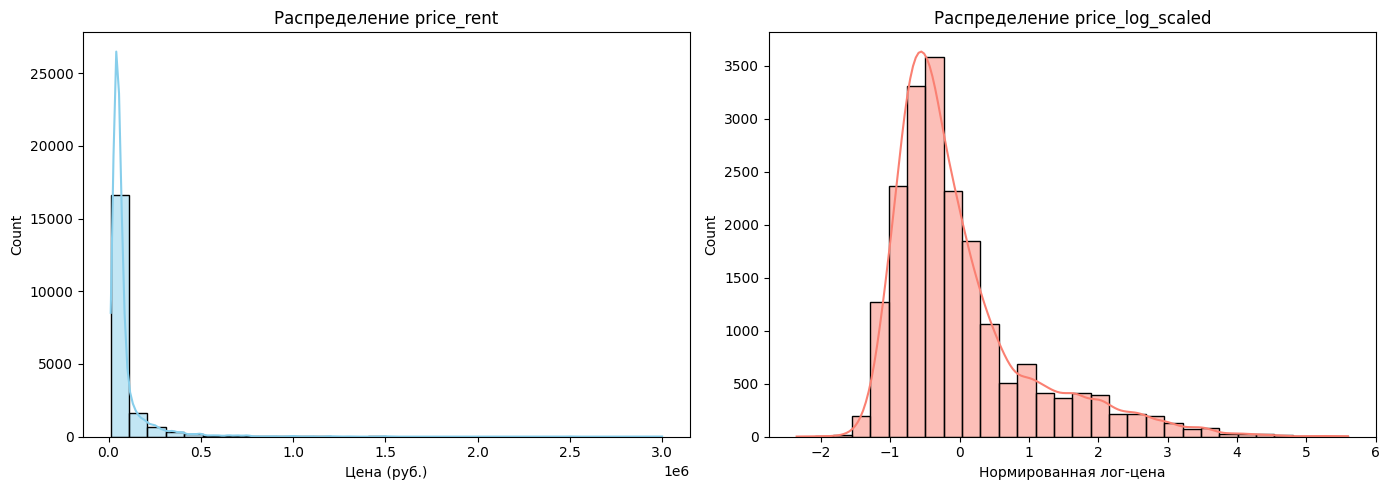

In [80]:
plot_hist_target(data_df_new)

корреляция признаков

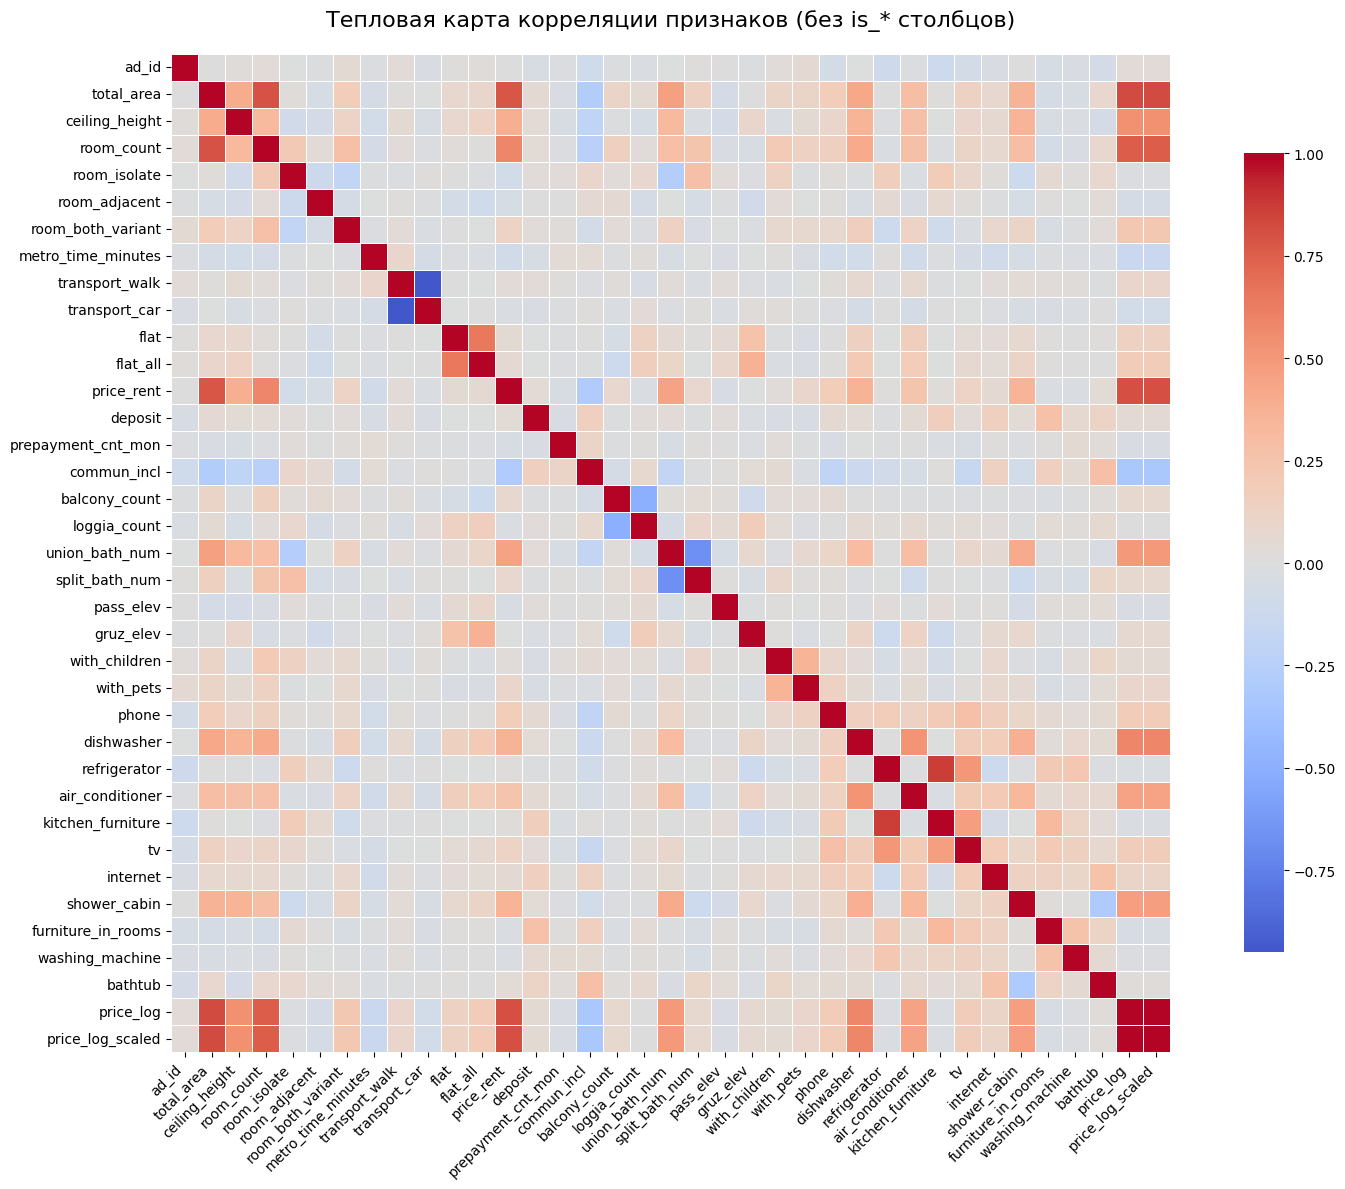

In [81]:
plot_heatmap(data_df_new)

контрольная проверка пропусков перед сохранением

In [82]:
# выбираем пропущенные значения из датафрейма
print(show_empty(data_df))

Доли пустых значений в датафрейме по столбцам
                      Название столбца  Процент пропусков, %
0                                ad_id                   0.0
1                                rooms                   0.0
2                              address                   0.0
3                           total_area                   0.0
4                        building_type                   0.0
...                                ...                   ...
2059        is_street_zubovskii_proezd                   0.0
2060  is_street_zvenigorodskaia_ulitsa                   0.0
2061    is_street_zverinetskaia_ulitsa                   0.0
2062        is_street_zvezdnyi_bul_var                   0.0
2063     is_street_zvonarskii_pereulok                   0.0

[2064 rows x 2 columns]


Сохраняем датафрейм с очищенными и нормализованными данными

In [83]:
data_df_new.to_csv('stars25_dan_data.csv', index=False)

Очищенный файл сохранен в stars25_dan_data.csv